In [25]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv("output/2D_magnetosphere.csv")
data.head()

,fileid,cellid,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,...,s24_kurt,s24_zeros,mean,zeros,partials,gap,spatial_x,spatial_y,spatial_z,pngfile
0,4000,1,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-599850000.0,0.0,-359850000.0,f0004000c00001.png
1,4000,51,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-584850000.0,0.0,-359850000.0,f0004000c00051.png
2,4000,101,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-569850000.0,0.0,-359850000.0,f0004000c00101.png
3,4000,151,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-554850000.0,0.0,-359850000.0,f0004000c00151.png
4,4000,201,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,...,-3.0,1.0,0.000024,0.76,0.08,0,-539850000.0,0.0,-359850000.0,f0004000c00201.png


In [3]:
data.shape

(2871, 210)

Let's remove the features that do not contain relevant information: "fileid", "cellid", "spatial_x", "spatial_y", "spatial_z", "pngfile".

In [6]:
features = data.drop(["fileid", "cellid", "spatial_x", "spatial_y", "spatial_z", "pngfile"], axis=1)
features.head(1)

,s0_min,s0_max,s0_mean,s0_median,s0_var,s0_skew,s0_kurt,s0_zeros,s1_min,s1_max,...,s24_mean,s24_median,s24_var,s24_skew,s24_kurt,s24_zeros,mean,zeros,partials,gap
0,0.000338,0.000562,0.000445,0.000452,2.867838e-09,0.080865,-0.931964,0.0,0.000068,0.000253,...,0.0,0.0,0.0,0.0,-3.0,1.0,0.000024,0.76,0.08,0


In [49]:
features.shape

(2871, 204)

Let's apply PCA to reduce the dimensionality of the input space and use only the principal components with the highest variance.

In [9]:
X = StandardScaler().fit_transform(features)

pca = PCA(n_components=0.9)
pca_res = pca.fit_transform(X)
pca_res.shape

(2871, 29)

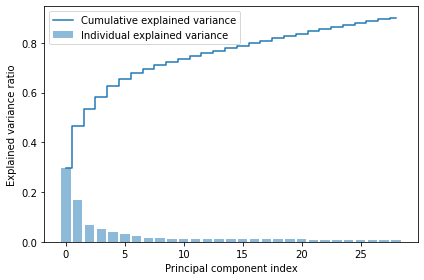

In [10]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The input feature space has been reduce from 210 to 29 dimensions.
These 29 dimensions are the first (most important) principal components that explain 90% of the variance in the data.

## K-means
Let's first try K-means clustering to see if these features achieve similar performance as that obtained by Simo.

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', kmeans.labels_)

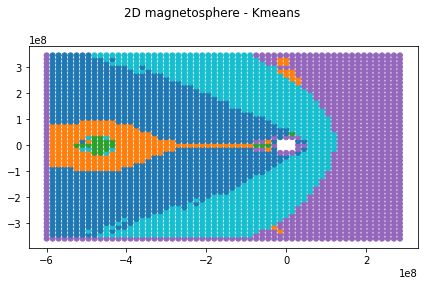

In [48]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - Kmeans')
plt.tight_layout()

## Affinity propagation

In [51]:
from sklearn.cluster import AffinityPropagation

affinity = AffinityPropagation(damping=0.9)
affinity.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', affinity.labels_)

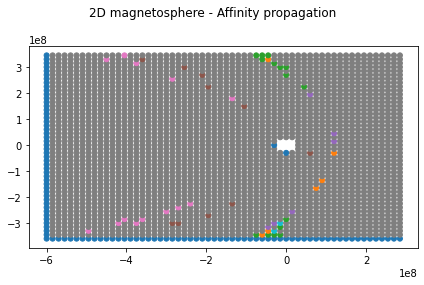

In [52]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - Affinity propagation')
plt.tight_layout()

We see some sort of magnetosphere limits but overall the performance is non existent.
Testing other damping factors yield no convergence.

## Agglomerative clustering

In [68]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_model = AgglomerativeClustering(n_clusters=5)
agglomerative_model.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', agglomerative_model.labels_)

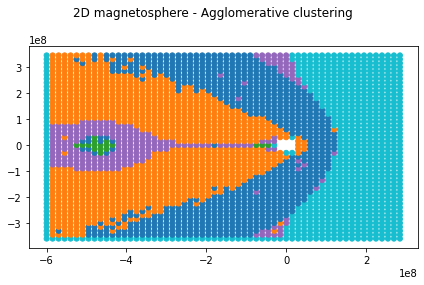

In [69]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - Agglomerative clustering')
plt.tight_layout()

## BIRCH

In [72]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=5)
birch.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', birch.labels_)

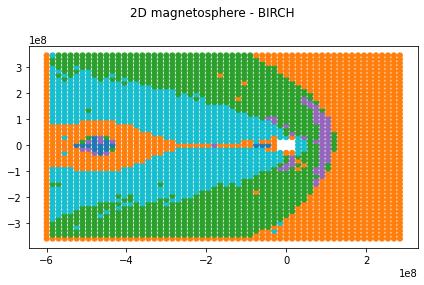

In [73]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - BIRCH')
plt.tight_layout()

In [99]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3, min_samples=3)
dbscan.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', dbscan.labels_)

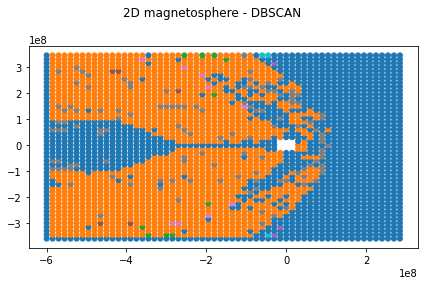

In [100]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - DBSCAN')
plt.tight_layout()

## Mini-Batch K-Means

In [102]:
from sklearn.cluster import MiniBatchKMeans

miniKmeans = MiniBatchKMeans(n_clusters=5)
miniKmeans.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', miniKmeans.labels_)

C:\Users\ansni\anaconda3\envs\plasma\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


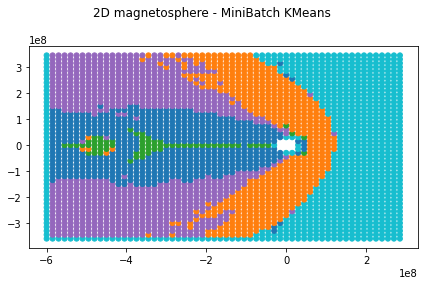

In [103]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - MiniBatch KMeans')
plt.tight_layout()

## Mean shift

In [118]:
from sklearn.cluster import MeanShift

mean_shift = MeanShift()
mean_shift.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', mean_shift.labels_)

KeyboardInterrupt: 

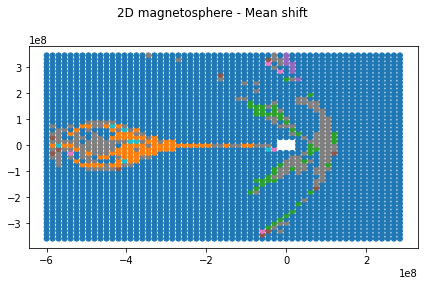

In [ ]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - Mean shift')
plt.tight_layout()

## OPTICS

In [ ]:
from sklearn.cluster import OPTICS

optics = OPTICS(eps=0.3, min_samples=10)
optics.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', optics.labels_)

C:\Users\ansni\anaconda3\envs\plasma\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


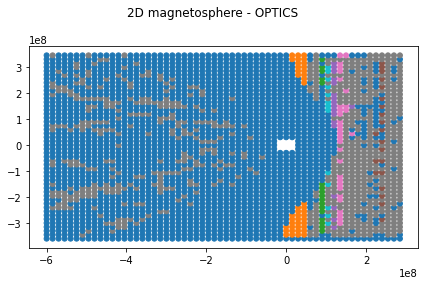

In [ ]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - OPTICS')
plt.tight_layout()

## Spectral clustering

In [119]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=5)
spectral_clustering.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', spectral_clustering.labels_)

C:\Users\ansni\anaconda3\envs\plasma\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


KeyboardInterrupt: 

## Gaussian mixture model

In [128]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6)
gmm.fit(pca_res)

data_copy = data.copy()
data_copy.insert(0, 'class', gmm.predict(pca_res))

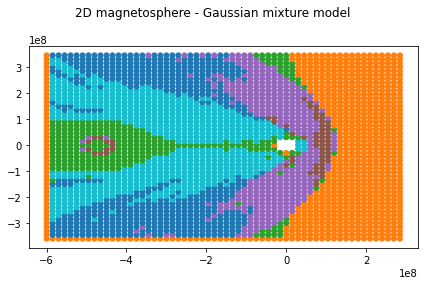

In [129]:
cmap = mpl.colors.ListedColormap(['C0', 'C1', 'C2', 'C9', 'C4', 'C5', 'C6', 'C7'])
norm = mpl.colors.BoundaryNorm(np.arange(8+1)-0.5, cmap.N)

plt.scatter(data_copy['spatial_x'], data_copy['spatial_z'], c=data_copy['class'], s=25, cmap=cmap, norm=norm)
plt.suptitle('2D magnetosphere - Gaussian mixture model')
plt.tight_layout()